# TODO
 ~~- grid search for parameters~~
 - figure out parameters in surrogate rewards
 ~~- make rewards non binary in environment and surrogate rewards~~
 ~~- add deceay from papers, log and other~~
 - initiate q-table at `-1`?
 - run experiment with different `correct_action`
 - should we be setting up the glove for `very distinguishable` levels? Shouldn't we set it up with `barely distinguishable` levels, as this is where the perturbed rewards come on - they'd help us get through the noise and find the correct level.

# Scripts

In [1]:
import numpy as np
import collections
import pandas as pd
import argparse
import time
import numpy as np

In [2]:
import noise_estimator

In [3]:
# from ucbq_agent import UCBQAgent
from ucbq_agent_stateless import UCBQAgent
# from ucbq_environment import ModifiedRandomEnvironment
from ucbq_environment_stateless import ModifiedRandomEnvironment

# Params

In [30]:
max_steps = 120
num_episodes = 1

In [6]:
timeOut = None
num_states = 7
# start_state = 1
start_action = 0

In [7]:
# zero indexed
correct_action = 6

In [8]:
def default_params():
    """ These are the default parameters used int eh framework. """
    return {
            # # Runner parameters
            # 'max_episodes': int(1E6),         # experiment stops after this many episodes
            # 'max_steps': int(1E9),            # experiment stops after this many steps
            # 'multi_runner': False,            # uses multiple runners if True
            # # Exploration parameters
            # 'epsilon_anneal_time': int(5E3),  # exploration anneals epsilon over these many steps
            # 'epsilon_finish': 0.1,            # annealing stops at (and keeps) this epsilon
            # 'epsilon_start': 1,               # annealing starts at this epsilon
            'epsilon': 1,               # annealing starts at this epsilon
            'epsilon_decay': 0.5,
            # Optimization parameters
            'alpha': 0.5,                       # learning rate of optimizer
            # 'gamma': 0.99,                    # discount factor gamma
           }

# Scripts

In [9]:
import matplotlib.pyplot as plt

In [10]:
from tqdm import tqdm 

In [11]:
def print_agent_stats(agent):
    print(f'Q-table:')
    print(f'{np.around(agent.Q, decimals=4)}')
    print(f'Number of times action was taken:')
    print(f'{agent.N}')
    print(f'Total timesteps: {sum(sum(agent.N)) - 100}')
    # print(f'Episode rewards: {episode_rewards}')

def get_mean_across_episodes(arr):
    min_cols = np.amin([len(row) for row in arr])
    truncated_arr = [ x[:min_cols] for x in arr ]
    res = np.array(truncated_arr)
    mean = res.mean(axis=0)

    return mean    

def get_cumsum_rewards(rewards):
    cumulative_sum_rewards = np.cumsum(rewards)
    time_steps = np.arange(1, len(rewards) + 1)
    mean_rewards = cumulative_sum_rewards / time_steps
    return mean_rewards

In [12]:
def runner(adjust_rewards=None, 
           agent=None,
           env=None,
           params=default_params()):

    agent = agent if agent else UCBQAgent(num_actions=num_states)
    env = env if env else ModifiedRandomEnvironment()
    start_time = time.time()
    t = 0
    episode_rewards = 0
    q_values_for_chart = []
    rewards = []
    # state = start_state
    action = start_action
    state = 0
    same_action = None

    while True:
        elapsed_time = time.time() - start_time

        # Auto shut down scipt 
        if bool(timeOut) and (elapsed_time > float(timeOut)):
            break

        if t >= max_steps:
            break

        action = agent.choose_action(state) 
        # TODO: 
        # send_action_to_stream
        reward, next_state = env.step(action)
        
        rewards.append(reward)

        if adjust_rewards:
            reward = adjust_rewards(reward, state, action)
        
        # print(f"{round(elapsed_time, 2)} > {action} -> {reward}")
        
        agent.learn(state, action, reward, next_state)
        # state = next_state

        episode_rewards += reward

        t += 1

        # if agent.epsilon > agent.epsilon_min:
        #     agent.epsilon *= 0.5

        # if agent.alpha > agent.alpha_min:
        #     agent.alpha *= 0.8


        # if agent.epsilon > agent.epsilon_min:
        #     agent.epsilon *= params['epsilon_decay']


        # if agent.epsilon > agent.epsilon_min:
        #     agent.epsilon -= agent.epsilon_decay(t)

        # if agent.alpha > agent.alpha_min:
        #     agent.alpha -= agent.alpha_decay(t)

        if agent.epsilon > agent.epsilon_min:
            epsilon_decay = lambda t: np.log10(t+1)/params['epsilon_decay']
            agent.epsilon -= epsilon_decay(t)

        if t % 10 == 0:
            sum_q_values_across_states = np.around(np.sum(agent.Q, axis=0), decimals=4)
            q_values_for_chart.append(sum_q_values_across_states)
            # print(agent.alpha, agent.epsilon)

        #TODO: this should be part of the environment
        #action picked
        consecutive_limit = 15
        if t > 35:
            if action == same_action:
                consecutive_count += 1
                if consecutive_count >= consecutive_limit:
                    # tqdm.write(f"Selected action {action} - breaking loop at iteration {t} - consecutive count: {consecutive_count}")
                    break
            else:
                same_action = action
                consecutive_count = 1

    # # plt.plot(q_values_for_chart)
    # fig = plt.gcf()
    # fig.set_size_inches(18, 4)
    # plt.plot(rewards)
    
    episode_length = t + 1
    selected_action = action 
    
    if t >= max_steps:
        sum_q_values_across_states = np.around(np.sum(agent.Q, axis=0), decimals=4)
        selected_action = np.argmax(sum_q_values_across_states)


    return q_values_for_chart, rewards, episode_length, selected_action

In [13]:
def qLearningExperiment(difference_fn=None, params=default_params()):
    q_values_all_experiments = []
    rewards_all_experiments = []
    episode_lengths = []
    selected_actions = []

    for i in tqdm(range(num_episodes)):
        agent = UCBQAgent(params=params)
        env = ModifiedRandomEnvironment(correct_action=correct_action)
        q_values_for_chart, rewards, episode_length, selected_action = runner(difference_fn, env=env, agent=agent, params=params)
        rewards_all_experiments.append(rewards)
        q_values_all_experiments.append(q_values_for_chart)
        episode_lengths.append(episode_length)
        selected_actions.append(selected_action)

    count = selected_actions.count(correct_action)
    accuracy = (count / len(selected_actions)) * 100
    
    return q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy


In [14]:
def plot_mean_q_values(difference_fn=None):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(difference_fn)

    all_mean_rewards = [ get_cumsum_rewards(rewards) for rewards in rewards_all_experiments ]

    all_mean_rewards = pd.DataFrame(all_mean_rewards) # rewards have different lengths
    # because they terminate earlier sometimes
    mean_matrix = np.mean(all_mean_rewards, axis=0)
    mean_dataframe = pd.DataFrame(mean_matrix)
    mean_dataframe.plot()

    mean_matrix = get_mean_across_episodes(q_values_all_experiments)
    mean_dataframe = pd.DataFrame(mean_matrix)

    mean_dataframe.plot()

    pd.DataFrame(episode_lengths).plot()
    print(f'Mean episode length: {np.mean(episode_lengths)}') 
    pd.DataFrame(selected_actions).plot()

    print(f'Accuracy: {accuracy}')

# Real rewards UCB Q-learning

In [15]:
rewards_all_experiments = []

qs, rewards, _, _ = runner()
rewards_all_experiments.append(rewards)

In [16]:
agent = UCBQAgent(num_actions=num_states)
runner(agent=agent)
print_agent_stats(agent)

Q-table:
[[-3.     -2.5    -2.     -2.25   -1.5    -0.9375  0.    ]]
Number of times action was taken:
[[ 2.  2.  2.  3.  3.  5. 50.]]
Total timesteps: -33.0


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

Mean episode length: 61.0
Accuracy: 100.0


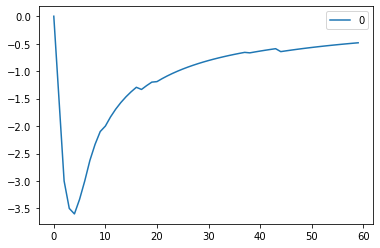

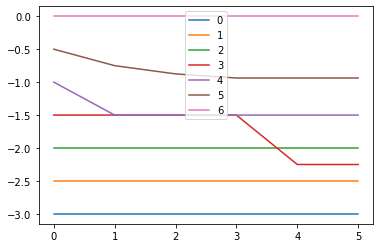

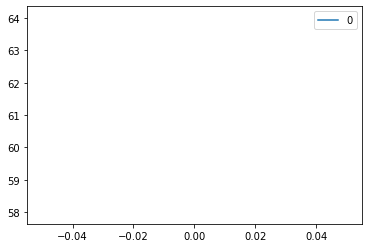

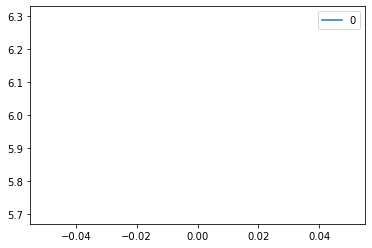

In [17]:
# The Q-value shape make sense - we're trying higher numbers later
# so they converge to -1 slower than e.g. action 0 or 1
plot_mean_q_values()

# Noisy rewards
- rewards are now noisy
- q-learner hasn't changed

In [18]:
# Generate confusion matrix
noise_estimator.initialize_cmat("anti_iden", 7, 0.2)

(array([[0.8, 0. , 0. , 0. , 0. , 0. , 0.2],
        [0. , 0.8, 0. , 0. , 0. , 0.2, 0. ],
        [0. , 0. , 0.8, 0. , 0.2, 0. , 0. ],
        [0. , 0. , 0. , 1. , 0. , 0. , 0. ],
        [0. , 0. , 0.2, 0. , 0.8, 0. , 0. ],
        [0. , 0.2, 0. , 0. , 0. , 0.8, 0. ],
        [0.2, 0. , 0. , 0. , 0. , 0. , 0.8]]),
 1)

In [19]:
from modified_pendulum_processor import ModifiedPendulumProcessor

100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

Mean episode length: 121.0
Accuracy: 0.0
[[0.8 0.  0.  0.  0.  0.  0.2]
 [0.  0.8 0.  0.  0.  0.2 0. ]
 [0.  0.  0.8 0.  0.2 0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.2 0.  0.8 0.  0. ]
 [0.  0.2 0.  0.  0.  0.8 0. ]
 [0.2 0.  0.  0.  0.  0.  0.8]]
{(0, 4): [-2, -2, -2, -2, -2, -2, -2, -4, -2, -2, -4, -2, -4, -2, -2, -2, -2, -2, -2], (0, 0): [-6, -6, -6, -6, 0, -6, -6, -6], (0, 1): [-5, -5, -5, -1, -1, -5, -1, -5, -5, -5, -5], (0, 2): [-4, -2, -4, -4, -4, -4, -4, -4, -4, -4, -2], (0, 3): [-3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3], (0, 5): [-1, -1, -1, -1, -1, -5, -1, -1, -5, -5, -5, -1, -1, -1, -1, -1, -5, -1, -1, -1, -1, -5], (0, 6): [-6, 0, 0, 0, 0, -6, 0, 0, 0, 0, 0, 0, 0, -6, 0, 0, 0, 0, 0, 0, -6, 0, 0, 0, 0, 0, 0, 0, -6, 0, 0, -6, 0, -6, -6]}
Estimated confusion matrix:
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


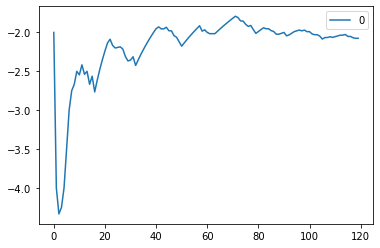

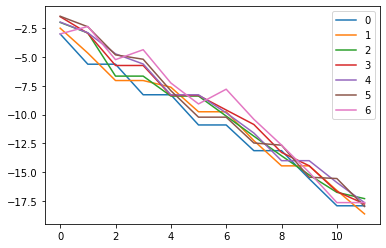

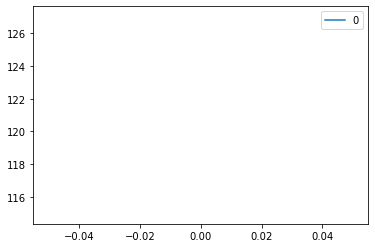

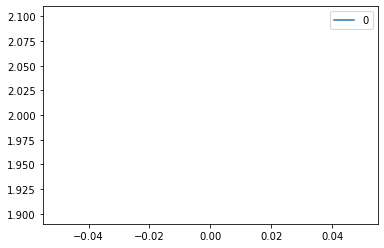

In [20]:
post_processor = ModifiedPendulumProcessor(surrogate=False)

def adjust_rewards_noisy(reward, state, action):    
    observation, reward, done, info = post_processor.process_step(state, reward, None, None, action)
    return reward

plot_mean_q_values(adjust_rewards_noisy)
print(post_processor.cmat)
print(post_processor.r_sets)
print('Estimated confusion matrix:')
print(np.around(post_processor.C, decimals=4))

# Surrogate rewards

100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Mean episode length: 97.0
Accuracy: 100.0
[[0.8 0.  0.  0.  0.  0.  0.2]
 [0.  0.8 0.  0.  0.  0.2 0. ]
 [0.  0.  0.8 0.  0.2 0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.2 0.  0.8 0.  0. ]
 [0.  0.2 0.  0.  0.  0.8 0. ]
 [0.2 0.  0.  0.  0.  0.  0.8]]
{(0, 4): [-2, -4, -2, -2, -2, -2, -4, -2, -2, -2, -2, -2, -2, -2, -2, -2, -4, -2], (0, 0): [0, -6, -6, -6, 0, -6], (0, 1): [-1, -5, -5, -5, -1, -5, -5], (0, 2): [-4, -2, -4, -4, -4, -4, -4, -2, -4], (0, 3): [-3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3], (0, 5): [-1, -1, -5, -1, -1, -1, -1, -1, -1, -5, -5, -1, -1, -1, -1, -1, -1, -5, -1, -1, -1, -1, -5, -1, -5], (0, 6): [0, 0, -6, -6, -6, 0, 0, -6, 0, -6, 0, 0, 0, 0, 0, -6, 0, 0, -6, 0]}
Estimated confusion matrix:
[[0.65   0.     0.     0.     0.     0.     0.35  ]
 [0.     0.76   0.     0.     0.     0.24   0.    ]
 [0.     0.     0.8333 0.     0.1667 0.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.2222 0.     0.7778 0.     0.    ]
 [0.     0.2

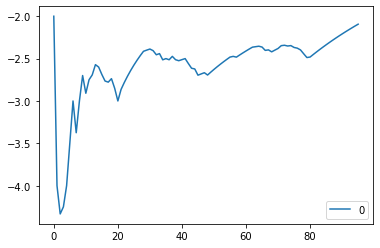

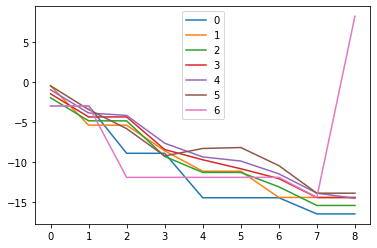

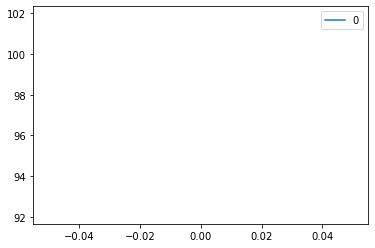

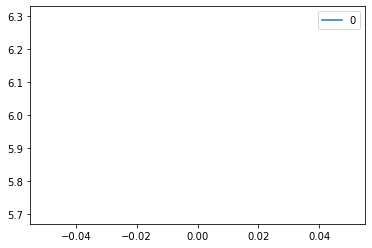

In [31]:
post_processor = ModifiedPendulumProcessor(surrogate=True)

def adjust_rewards(reward, state, action):    
    observation, reward, done, info = post_processor.process_step(state, reward, None, None, action)
    return reward

plot_mean_q_values(adjust_rewards)

print(post_processor.cmat)
print(post_processor.r_sets)
print('Estimated confusion matrix:')
print(np.around(post_processor.C, decimals=4))

# Hyperparameter tuning

In [23]:
max_steps = 120
num_episodes = 100

print('Accuracy should be higher, timsteps should be lower')
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(adjust_rewards_noisy)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(adjust_rewards_surrogate)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

Accuracy should be higher, timsteps should be lower


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


65.0 111.54


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]

60.0 114.06


In [24]:
from sklearn.model_selection import ParameterGrid

In [25]:
from IPython import display
import pandas as pd

In [26]:
max_steps = 120
num_episodes = 20

param_grid = {
    'alpha': [0.1, 1.0],
    'epsilon': [0.1, 1.0],
    # 'epsilon_decay': [0.1, 1.0],
    'epsilon_decay': [10, 20, 40, 80],
    }

param_grid_out = pd.DataFrame(ParameterGrid(param_grid))

def get_results_from_grid_row(params):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(adjust_rewards_surrogate_simple, params=params)
    mean_episode_length = np.mean(episode_lengths)
    print(accuracy, mean_episode_length) 

    return accuracy, mean_episode_length

for i, params in tqdm(param_grid_out.iterrows(), total=param_grid_out.shape[0]):
    accuracy, mean_episode_length = get_results_from_grid_row(params)
    param_grid_out.loc[i, 'accuracy'] = accuracy
    param_grid_out.loc[i, 'mean_episode_length'] = mean_episode_length
    # display.clear_output()

  0%|          | 0/16 [00:00<?, ?it/s]

NameError: name 'adjust_rewards_surrogate_simple' is not defined

In [ ]:
print(param_grid_out)

    alpha  epsilon  epsilon_decay  accuracy  mean_episode_length
0     0.1      0.1             10     100.0               121.00
1     0.1      0.1             20     100.0               121.00
2     0.1      0.1             40     100.0               121.00
3     0.1      0.1             80     100.0               121.00
4     0.1      1.0             10     100.0               121.00
5     0.1      1.0             20     100.0               121.00
6     0.1      1.0             40     100.0               121.00
7     0.1      1.0             80     100.0               121.00
8     1.0      0.1             10     100.0                73.65
9     1.0      0.1             20     100.0                73.95
10    1.0      0.1             40     100.0               108.00
11    1.0      0.1             80     100.0               114.60
12    1.0      1.0             10     100.0                71.05
13    1.0      1.0             20     100.0                75.40
14    1.0      1.0       

In [ ]:
# param_grid_out.iloc[0]['accuracy'] = 1
print(param_grid_out.sort_values(by=['accuracy', 'mean_episode_length'], ascending=True))

   alpha  epsilon  epsilon_decay  accuracy  mean_episode_length
4    1.0      0.1            0.1     100.0                88.40
6    1.0      1.0            0.1     100.0               101.85
5    1.0      0.1            1.0     100.0               111.30
0    0.1      0.1            0.1     100.0               121.00
1    0.1      0.1            1.0     100.0               121.00
2    0.1      1.0            0.1     100.0               121.00
3    0.1      1.0            1.0     100.0               121.00
7    1.0      1.0            1.0     100.0               121.00


# Q-value of "true" level compared accross different reward techniques

In [ ]:
#TODO:
# What if we reset the state to the original one, every 10 steps, and that would be our episode?
# -> keep the q-values, reset the parameters epsilon, learning rate, etc.

# Epsilon test

0.5


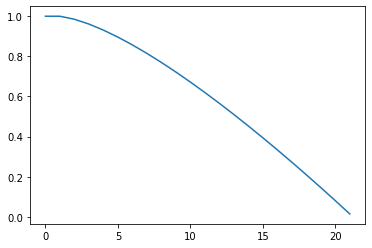

In [ ]:
agent = UCBQAgent(num_states=num_states)
epsilons = []
for t in range(200):
    if agent.epsilon > agent.epsilon_min:
        epsilons.append(agent.epsilon)
        agent.epsilon -= agent.epsilon_decay(t)

plt.plot(epsilons)